# Pitch Quality by Pitch Type

# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Preprocessing](#Preprocessing)
    - [Multicolinearity - VIF](#Multicolinearity---VIF)
- [Analysis](#Analysis)
    - [Run Value by Event](#Run-Value-for-Ball-in-Play-by-Events)
    - [Run Value by Count](#Run-Value-by-Count)
    - [Avg Run Value by Pitch Type](#Average-Run-Value-by-Pitch-Type)
- [4-Seam Analysis](#4-Seam-Analysis)
    - [Top 10 4-Seam xQual](#Top-10-4-Seam-xQual)
    - [4-Seam HB & VB](#4-Seam-HB-&-VB)
- [Cutter Analysis](#Cutter-Analysis)
    - [Top 10 Cutter xQual](#Top-10-Cutter-xQual)
    - [Cutter HB & VB](#Cutter-HB-&-VB)
- [Sinker Analysis](#Sinker-Analysis)
    - [Top 10 Sinker xQual](#Top-10-Sinker-xQual)
    - [Sinker HB & VB](#Sinker-HB-&-VB)
- [Slider Analysis](#Slider-Analysis)
    - [Top 10 Slider xQual](#Top-10-Slider-xQual)
    - [Slider HB & VB](#Slider-HB-&-VB)
- [Curveball Analysis](#Curveball-Analysis)
    - [Top 10 Curveball xQual](#Top-10-Curveball-xQual)
    - [Curveball HB & VB](#Curveball-HB-&-VB)
- [Changeup Analysis](#Changeup-Analysis)
    - [Top 10 Changeup xQual](#Top-10-Changeup-xQual)
    - [Changeup HB & VB](#Changeup-HB-&-VB)

# Imports

In [1]:
from sklearn.preprocessing import scale, StandardScaler
from matplotlib.patches import Rectangle
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/model-pitches-rv.csv', index_col = [0])
data.drop(columns = ['plate_x', 'release_pos_x'], inplace = True)
data.rename(columns = {'pfx_-x': 'pfx_x', 
                       'plate_-x': 'plate_x', 
                       'release_pos_-x': 'release_pos_x'}, 
            inplace = True)

xrv = pd.read_csv('../data/xrv-pitches.csv', index_col = [0])
rv_pitches = pd.read_csv('../data/pitches-rv-table.csv', index_col = [0])

pd.set_option('max_columns', None)
print(xrv.shape)
xrv.head()

(680883, 15)


,player_name,p_throws,pitch_type,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,arm_angle,slot,release_extension,rv,n_pitches,xRV
0,"Gsellman, Robert",R,FF,93.4,1999.0,8.16,10.68,1.71,5.85,28.8,1,6.3,0.014061,1,0.006940
1,"Martin, Chris",R,FF,95.3,2252.0,3.24,13.56,2.58,6.42,40.1,3,6.7,-0.043838,1,0.037270
2,"Martin, Chris",R,FF,94.9,2224.0,9.00,14.16,2.71,6.38,40.1,3,6.6,-0.177006,1,-0.105773
3,"Hembree, Heath",R,FF,93.5,2419.0,12.12,17.28,0.45,5.87,20.1,1,6.7,-0.202647,1,-0.128859
4,"Hembree, Heath",R,FF,95.5,2516.0,12.48,18.24,0.55,5.91,20.1,1,6.6,-0.028122,1,-0.020058


In [3]:
print(rv_pitches.shape)
rv_pitches.head()

(3346, 14)


,player_name,p_throws,pitch_type,n_pitches,velo,HB,VB,arm_angle,slot,release_extension,RV,RV/100,xRV,xRV/100
0,"Abbott, Cory",R,FF,207.0,92.6,9.6,17.2,43.3,2.0,6.2,3.6,1.7,3.4,1.6
1,"Abreu, Albert",R,FF,103.0,97.8,11.7,15.4,40.8,3.0,6.4,-2.0,-1.9,-2.5,-2.4
2,"Abreu, Bryan",R,FF,310.0,95.7,8.0,17.1,28.7,1.0,6.3,-3.4,-1.1,-6.4,-2.1
3,"Acevedo, Domingo",R,FF,88.0,92.9,12.2,15.1,31.0,1.0,5.8,1.3,1.5,1.2,1.3
4,"Adam, Jason",R,FF,125.0,93.8,7.0,16.8,34.5,1.0,6.7,1.5,1.2,-1.9,-1.5


# Preprocessing

In [4]:
ff = rv_pitches.loc[(rv_pitches['pitch_type'] == 'FF') & (rv_pitches['n_pitches'] > 100)]
fc = rv_pitches.loc[(rv_pitches['pitch_type'] == 'FC') & (rv_pitches['n_pitches'] > 100)]
si = rv_pitches.loc[(rv_pitches['pitch_type'] == 'SI') & (rv_pitches['n_pitches'] > 100)]
sl = rv_pitches.loc[(rv_pitches['pitch_type'] == 'SL') & (rv_pitches['n_pitches'] > 100)]
cu = rv_pitches.loc[(rv_pitches['pitch_type'] == 'CU') & (rv_pitches['n_pitches'] > 100)]
ch = rv_pitches.loc[(rv_pitches['pitch_type'] == 'CH') & (rv_pitches['n_pitches'] > 100)]

ff_stats = xrv.loc[xrv['pitch_type'] == 'FF']
fc_stats = xrv.loc[xrv['pitch_type'] == 'FC']
si_stats = xrv.loc[xrv['pitch_type'] == 'SI']
sl_stats = xrv.loc[xrv['pitch_type'] == 'SL']
cu_stats = xrv.loc[xrv['pitch_type'] == 'CU']
ch_stats = xrv.loc[xrv['pitch_type'] == 'CH']

### Multicolinearity - VIF

**Independent Variables:** Velocity, Spin Rate, VB, HB, Release Extension, Horizontal Release Position, Vertical Release Position, Horizontal Plate Coords, Vertical Plate Coords

**Dependent Variable:** rv

In [5]:
features = data[['player_name', 'p_throws', 'pitch_type', 'velo', 'spin_rate', 
                 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 'arm_angle',
                 'release_extension', 'rv']]

features_vif = features.select_dtypes([np.number])
vif_data = pd.DataFrame()
vif_data["feature"] = features_vif.columns

vif_data["VIF"] = [variance_inflation_factor(features_vif.values, i)
                   for i in range(len(features_vif.columns))]

print(vif_data.sort_values(by = 'VIF'))

             feature         VIF
8                 rv    1.011820
2              pfx_x    1.381995
4      release_pos_x    2.456688
3              pfx_z    3.112930
6          arm_angle    8.860496
1          spin_rate   50.640764
5      release_pos_z  127.152933
7  release_extension  162.940014
0               velo  298.874018


# Analysis

### Run Value for Ball in Play by Events

In [6]:
data.groupby(['events'], as_index = False)['re24', 'lin_weight_above_outs', 
                                           'lin_weights_above_outs_scale', 'rv'].mean()

,events,re24,lin_weight_above_outs,lin_weights_above_outs_scale,rv
0,double,0.770147,1.041,1.259,0.572873
1,field_error,0.445453,0.716,0.866,0.298968
2,field_out,-0.271404,0.000,0.000,-0.307975
3,hit_by_pitch,0.359255,0.630,0.762,0.337445
4,home_run,1.385794,1.657,2.003,1.085243
5,single,0.474625,0.746,0.902,0.325699
6,triple,1.062984,1.334,1.613,0.814760
7,walk,0.332291,0.603,0.729,0.419974


### Run Value by Count

In [7]:
data.groupby(['pitch_count'], as_index = False)['woba', 'wraa_change', 'rv'].mean()

,pitch_count,woba,wraa_change,rv
0,0-0,0.314,-0.009615,-0.001082
1,0-1,0.265,-0.018637,-0.009369
2,0-2,0.197,-0.067643,-0.096349
3,1-0,0.356,-0.008226,0.001106
4,1-1,0.300,-0.021004,-0.006760
...,...,...,...,...
7,2-1,0.357,-0.018046,-0.002737
8,2-2,0.269,-0.105299,-0.125028
9,3-0,0.540,0.006415,0.106979
10,3-1,0.477,-0.006323,0.091440


### Average Run Value by Pitch Type

In [8]:
xrv.groupby(['pitch_type'], as_index = False, sort = False)['rv', 'xRV'].mean()

,pitch_type,rv,xRV
0,FF,-0.020096,-0.017270
1,FC,-0.019965,-0.018022
2,SI,-0.013897,-0.011623
3,SL,-0.033545,-0.032990
4,CU,-0.031498,-0.031145
5,CH,-0.026356,-0.024564


In [9]:
rv_pitches.groupby(['pitch_type'], as_index = False, sort = False)['RV/100', 'xRV/100'].mean()

,pitch_type,RV/100,xRV/100
0,FF,-1.118804,-0.984433
1,FC,-0.586283,-0.911062
2,SI,-0.825540,-0.582711
3,SL,-2.465116,-2.457703
4,CU,-1.524359,-1.573504
5,CH,-1.532055,-1.583742


# 4-Seam Analysis

In [10]:
ff_r_stats = ff_stats.loc[ff_stats['p_throws'] == 'R']
ff_l_stats = ff_stats.loc[ff_stats['p_throws'] == 'L']

ff_r_avg = ff_r_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
ff_l_avg = ff_l_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
ff_avg = pd.concat([ff_r_avg, ff_l_avg], ignore_index = True)
ff_avg = ff_avg.round(1)
ff_avg.head()

,pitch_type,p_throws,velo,spin_rate,pfx_x,pfx_z,release_pos_z,release_extension
0,FF,R,94.1,2283.3,7.1,16.1,5.9,6.4
1,FF,L,92.8,2249.4,-7.5,16.2,6.0,6.3


In [11]:
ff_stats[['rv', 'xRV']].describe()

,rv,xRV
count,249663.000000,249663.000000
mean,-0.020096,-0.017270
std,0.225211,0.128724
min,-1.503722,-0.984359
25%,-0.049628,-0.051671
50%,-0.028122,-0.019305
75%,0.023160,0.013623
max,3.081886,2.095757


### Top 10 4-Seam xQual

In [12]:
ff_stats['RV/100'] = ((ff_stats['rv'] / ff_stats['n_pitches']) * 100)
ff_stats['xRV/100'] = ((ff_stats['xRV'] / ff_stats['n_pitches']) * 100)

cols = list(ff_stats[['rv', 'xRV', 'RV/100', 'xRV/100']])
ff_stats[cols]

for col in cols:
    col_zscore = col + '_zscore'
    ff_stats[col_zscore] = ((ff_stats[col] - ff_stats[col].mean()) / ff_stats[col].std(ddof = 0) * -1)

stats = ff_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                         as_index = False)['n_pitches', 'rv', 'xRV', 'rv_zscore', 'xRV_zscore'].sum()

ff_stats = pd.merge(ff_stats, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
ff_stats['Qual'] = ff_stats['rv_zscore_y'] + 100
ff_stats['xQual'] = ff_stats['xRV_zscore_y'] + 100
ff_r_stats = ff_stats.loc[ff_stats['p_throws'] == 'R']
ff_l_stats = ff_stats.loc[ff_stats['p_throws'] == 'L']

q_stats = ff_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                           as_index = False)['velo', 'pfx_x', 'pfx_z', 'RV/100', 
                                             'xRV/100', 'Qual', 'xQual'].mean()

stats = pd.merge(stats, q_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
stats = stats.round(2)
stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'n_pitches', 'velo', 
                                 'pfx_x', 'pfx_z', 'rv', 'RV/100', 'Qual', 'xRV', 'xRV/100', 'xQual'])
ff_leaders = stats.sort_values(by = ['xQual'], ascending = False)
ff_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,rv,RV/100,Qual,xRV,xRV/100,xQual
765,"Wheeler, Zack",R,FF,1353,97.17,7.65,15.91,-52.82,-3.90,213.82,-56.09,-4.15,354.21
584,"Ray, Robbie",L,FF,1864,94.78,-8.18,17.13,-68.18,-3.66,236.43,-62.56,-3.36,335.95
137,"Cole, Gerrit",R,FF,1397,97.67,11.99,17.96,-50.63,-3.62,200.16,-52.45,-3.75,320.01
272,"Green, Chad",R,FF,853,95.69,4.47,19.32,-37.09,-4.35,188.57,-40.95,-4.80,303.71
783,"Woodruff, Brandon",R,FF,940,96.52,6.35,16.64,-44.81,-4.77,215.11,-41.61,-4.43,297.15
801,"deGrom, Jacob",R,FF,704,99.21,9.07,16.45,-33.26,-4.72,184.88,-35.49,-5.04,281.27
416,"Lynn, Lance",R,FF,1051,93.99,6.03,14.94,-41.28,-3.93,189.50,-41.47,-3.95,281.15
602,"Rodríguez, Richard",R,FF,812,93.09,13.43,15.17,-33.51,-4.13,176.34,-34.08,-4.20,255.81
642,"Scherzer, Max",R,FF,1316,94.30,10.61,16.03,-47.15,-3.58,191.92,-42.61,-3.24,254.44
9,"Akin, Keegan",L,FF,1009,92.02,-10.75,18.06,-35.96,-3.56,169.63,-36.91,-3.66,251.38


### RHP 4-Seam HB & VB

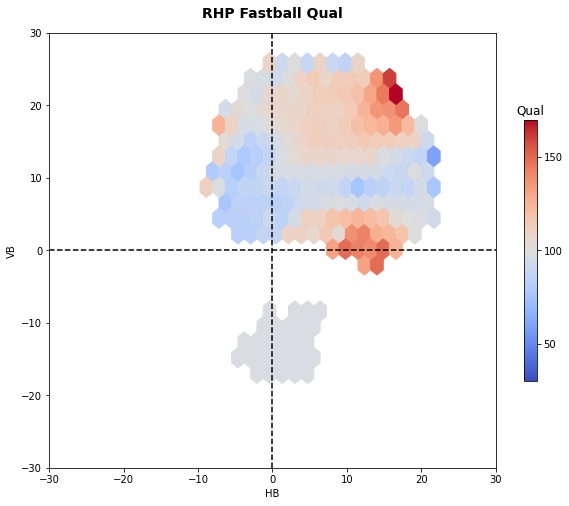

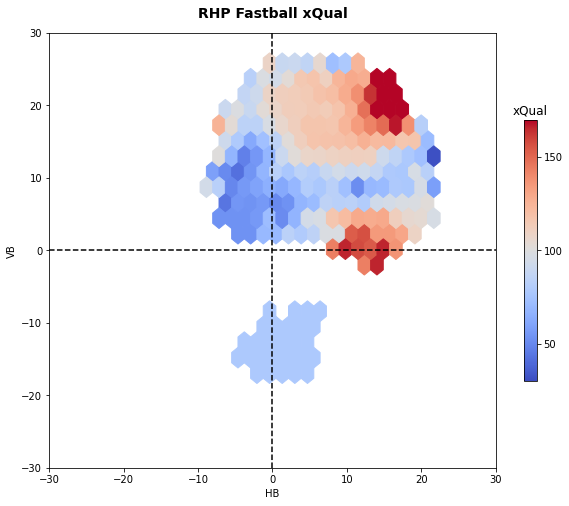

In [13]:
plt.figure(figsize = (10, 8))
plt.hexbin(ff_r_stats['pfx_x'], ff_r_stats['pfx_z'], C = ff_r_stats['Qual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(ff_r_stats['pfx_x'], ff_r_stats['pfx_z'], C = ff_r_stats['xQual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball xQual', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP 4-Seam HB & VB

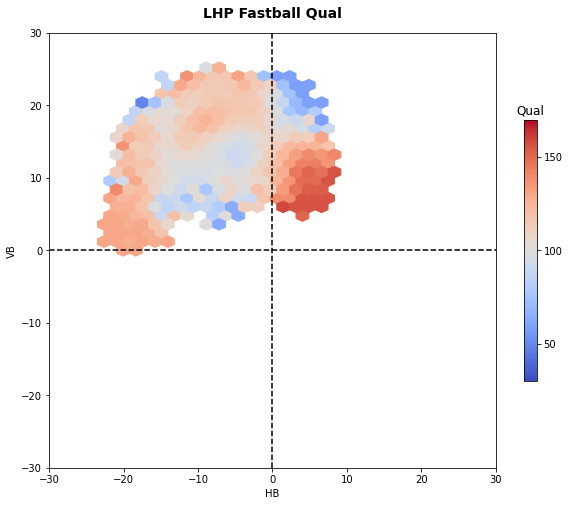

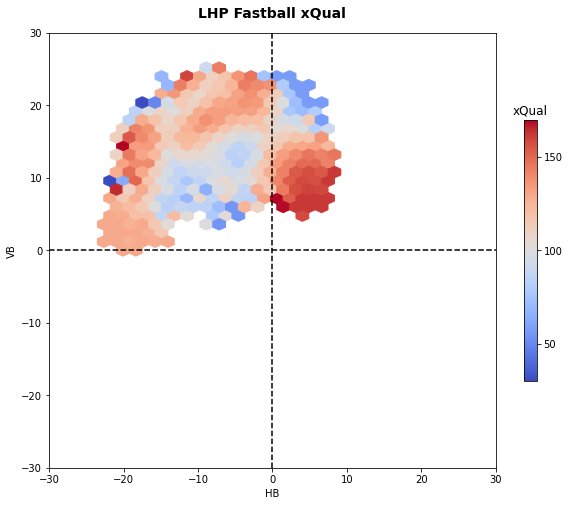

In [14]:
plt.figure(figsize = (10, 8))
plt.hexbin(ff_l_stats['pfx_x'], ff_l_stats['pfx_z'], C = ff_l_stats['Qual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Fastball Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(ff_l_stats['pfx_x'], ff_l_stats['pfx_z'], C = ff_l_stats['xQual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Fastball xQual', fontsize = 14, fontweight = 'bold', pad = 15);

# Cutter Analysis

In [15]:
fc_stats = xrv.loc[xrv['pitch_type'] == 'FC']
fc_r_stats = fc_stats.loc[fc_stats['p_throws'] == 'R']
fc_l_stats = fc_stats.loc[fc_stats['p_throws'] == 'L']

fc_r_avg = fc_r_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
fc_l_avg = fc_l_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
fc_avg = pd.concat([fc_r_avg, fc_l_avg], ignore_index = True)
fc_avg = fc_avg.round(1)
fc_avg.head()

,pitch_type,p_throws,velo,spin_rate,pfx_x,pfx_z,release_pos_z,release_extension
0,FC,R,89.5,2422.6,-3.0,7.9,5.9,6.3
1,FC,L,86.8,2267.2,1.7,7.9,5.8,6.2


In [16]:
fc_stats[['rv', 'xRV']].describe()

,rv,xRV
count,47442.000000,47442.000000
mean,-0.019965,-0.018022
std,0.230836,0.131151
min,-1.588089,-1.031770
25%,-0.049628,-0.052529
50%,-0.028122,-0.019673
75%,0.023160,0.014094
max,2.734491,1.946179


### Top 10 Cutter xQual

In [17]:
fc_stats['RV/100'] = ((fc_stats['rv'] / fc_stats['n_pitches']) * 100)
fc_stats['xRV/100'] = ((fc_stats['xRV'] / fc_stats['n_pitches']) * 100)

cols = list(fc_stats[['rv', 'xRV', 'RV/100', 'xRV/100']])
fc_stats[cols]

for col in cols:
    col_zscore = col + '_zscore'
    fc_stats[col_zscore] = ((fc_stats[col] - fc_stats[col].mean())/ fc_stats[col].std(ddof=0) * -1)

stats = fc_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                       as_index = False)['n_pitches', 'rv', 'xRV', 
                                         'rv_zscore', 'xRV_zscore'].sum()
fc_stats = pd.merge(fc_stats, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
fc_stats['Qual'] = fc_stats['rv_zscore_y'] + 100
fc_stats['xQual'] = fc_stats['xRV_zscore_y'] + 100
fc_r_stats = fc_stats.loc[fc_stats['p_throws'] == 'R']
fc_l_stats = fc_stats.loc[fc_stats['p_throws'] == 'L']
q_stats = fc_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                           as_index = False)['velo', 'pfx_x', 'pfx_z', 'RV/100', 
                                             'xRV/100', 'Qual', 'xQual'].mean()

stats = pd.merge(stats, q_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
stats = stats.round(2)
stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'n_pitches', 'velo', 
                                 'pfx_x', 'pfx_z', 'rv', 'RV/100', 'Qual', 'xRV', 'xRV/100', 'xQual'])
fc_leaders = stats.sort_values(by = ['xQual'], ascending = False)
fc_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,rv,RV/100,Qual,xRV,xRV/100,xQual
31,"Burnes, Corbin",R,FC,1354,95.23,-4.19,11.17,-42.98,-3.17,169.10,-44.29,-3.27,251.61
113,"Lynn, Lance",R,FC,775,88.67,-2.71,4.84,-29.59,-3.82,161.18,-30.95,-3.99,229.47
64,"Garcia, Luis",R,FC,565,86.10,-5.69,5.22,-31.25,-5.53,186.52,-22.36,-3.96,192.85
160,"Quantrill, Cal",R,FC,585,88.42,-2.55,6.18,-19.12,-3.27,132.24,-21.64,-3.70,184.62
9,"Anderson, Tyler",L,FC,702,85.02,2.15,9.75,-30.30,-4.32,170.56,-22.58,-3.22,175.74
38,"Clase, Emmanuel",R,FC,722,100.22,-2.73,10.66,-26.08,-3.61,150.52,-22.22,-3.08,170.20
194,"Thompson, Zach",R,FC,419,87.06,-3.78,5.44,-16.55,-3.95,135.48,-15.90,-3.79,163.66
4,"Alvarado, José",L,FC,170,94.11,1.26,5.10,-11.89,-6.99,136.81,-11.17,-6.57,161.84
35,"Chatwood, Tyler",R,FC,214,88.92,-4.79,0.59,-9.58,-4.48,123.00,-11.73,-5.48,160.05
49,"Detwiler, Ross",L,FC,325,85.15,0.42,4.94,-11.57,-3.56,122.03,-13.65,-4.20,159.40


### RHP Cutter HB & VB

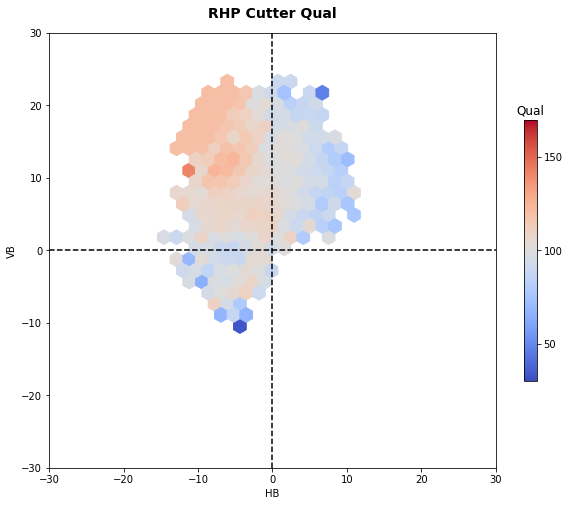

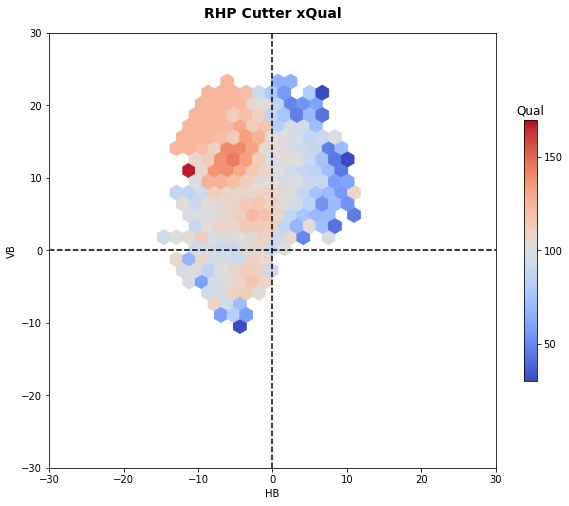

In [18]:
plt.figure(figsize = (10, 8))
plt.hexbin(fc_r_stats['pfx_x'], fc_r_stats['pfx_z'], C =fc_r_stats['Qual'], cmap ='coolwarm',mincnt=1,gridsize=20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Cutter Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(fc_r_stats['pfx_x'],fc_r_stats['pfx_z'],C = fc_r_stats['xQual'],cmap = 'coolwarm',mincnt=1,gridsize=20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Cutter xQual', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Cutter HB & VB

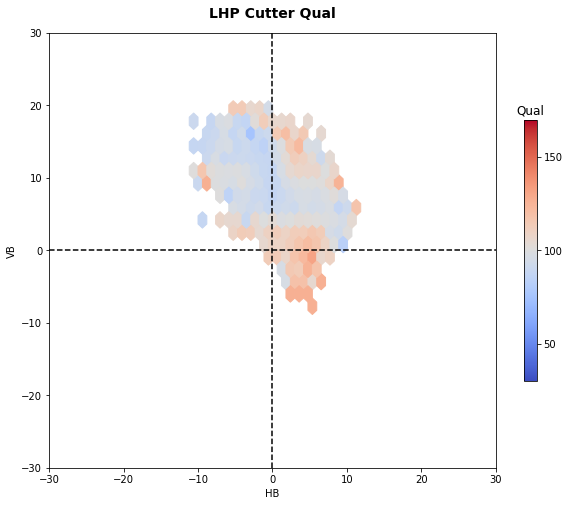

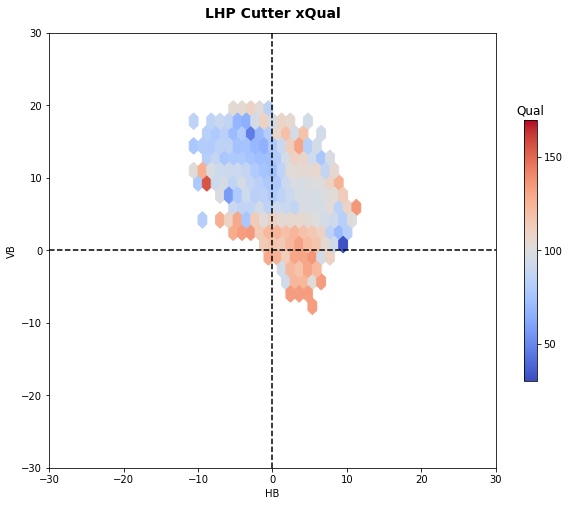

In [19]:
plt.figure(figsize = (10, 8))
plt.hexbin(fc_l_stats['pfx_x'], fc_l_stats['pfx_z'], C = fc_l_stats['Qual'],cmap='coolwarm',mincnt=1,gridsize=20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Cutter Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(fc_l_stats['pfx_x'], fc_l_stats['pfx_z'], C = fc_l_stats['xQual'],cmap='coolwarm',mincnt=1,gridsize=20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Cutter xQual', fontsize = 14, fontweight = 'bold', pad = 15);

# Sinker Analysis

In [20]:
si_stats = xrv.loc[xrv['pitch_type'] == 'SI']
si_stats = si_stats.round(1)
si_r_stats = si_stats.loc[si_stats['p_throws'] == 'R']
si_l_stats = si_stats.loc[si_stats['p_throws'] == 'L']

si_r_avg = si_r_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
si_l_avg = si_l_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
si_avg = pd.concat([si_r_avg, si_l_avg], ignore_index = True)
si_avg = si_avg.round(1)
si_avg.head()

,pitch_type,p_throws,velo,spin_rate,pfx_x,pfx_z,release_pos_z,release_extension
0,SI,R,93.4,2143.9,14.8,9.2,5.7,6.3
1,SI,L,92.1,2077.2,-15.0,9.3,5.8,6.3


In [21]:
si_stats[['rv', 'xRV']].describe()

,rv,xRV
count,109145.000000,109145.000000
mean,-0.005569,-0.009177
std,0.233081,0.134084
min,-1.500000,-1.100000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,2.700000,1.900000


### Top 10 Sinker xQual

In [22]:
si_stats['RV/100'] = ((si_stats['rv'] / si_stats['n_pitches']) * 100)
si_stats['xRV/100'] = ((si_stats['xRV'] / si_stats['n_pitches']) * 100)

cols = list(si_stats[['rv', 'xRV', 'RV/100', 'xRV/100']])
si_stats[cols]

for col in cols:
    col_zscore = col + '_zscore'
    si_stats[col_zscore] = ((si_stats[col] - si_stats[col].mean())/ si_stats[col].std(ddof=0) * -1)

stats = si_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                       as_index = False)['n_pitches', 'rv', 'xRV', 
                                         'rv_zscore', 'xRV_zscore'].sum()
si_stats = pd.merge(si_stats, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
si_stats['Qual'] = si_stats['rv_zscore_y'] + 100
si_stats['xQual'] = si_stats['xRV_zscore_y'] + 100
si_r_stats = si_stats.loc[si_stats['p_throws'] == 'R']
si_l_stats = si_stats.loc[si_stats['p_throws'] == 'L']
q_stats = si_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                           as_index = False)['velo', 'pfx_x', 'pfx_z', 'RV/100', 
                                             'xRV/100', 'Qual', 'xQual'].mean()

stats = pd.merge(stats, q_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
stats = stats.round(2)
stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'n_pitches', 'velo', 
                                 'pfx_x', 'pfx_z', 'rv', 'RV/100', 'Qual', 'xRV', 'xRV/100', 'xQual'])
si_leaders = stats.sort_values(by = ['xQual'], ascending = False)
si_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,rv,RV/100,Qual,xRV,xRV/100,xQual
436,"Suárez, Ranger",L,SI,734,92.95,-15.77,7.82,-29.1,-3.96,207.31,-37.0,-5.04,325.71
216,"Houser, Adrian",R,SI,1263,93.57,15.95,7.79,-27.6,-2.19,188.24,-40.9,-3.24,318.59
274,"Manaea, Sean",L,SI,1782,92.14,-13.79,12.28,-38.9,-2.18,224.32,-42.3,-2.37,293.51
285,"Matz, Steven",L,SI,1327,94.47,-15.04,12.30,-23.9,-1.80,170.84,-34.0,-2.56,262.75
262,"Loáisiga, Jonathan",R,SI,595,98.31,15.60,11.78,-21.2,-3.56,176.74,-25.6,-4.30,250.20
473,"Wainwright, Adam",R,SI,860,89.05,12.74,12.29,-29.4,-3.42,205.59,-25.5,-2.97,231.32
178,"Gray, Sonny",R,SI,651,92.42,13.17,9.57,-19.0,-2.92,165.96,-21.9,-3.36,218.78
484,"Wheeler, Zack",R,SI,580,96.70,15.70,11.43,-20.3,-3.50,173.24,-21.2,-3.66,218.41
7,"Alcantara, Sandy",R,SI,874,97.61,17.27,7.34,-15.3,-1.75,144.76,-23.3,-2.67,213.96
494,"Woodruff, Brandon",R,SI,749,96.24,13.96,12.77,-16.9,-2.26,154.61,-21.4,-2.86,208.34


### RHP Sinker HB & VB

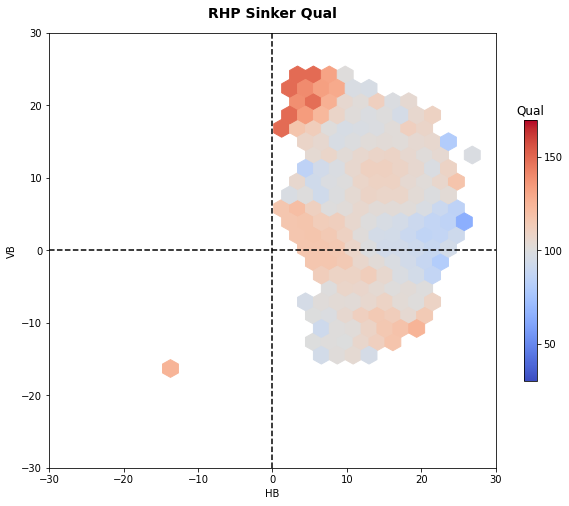

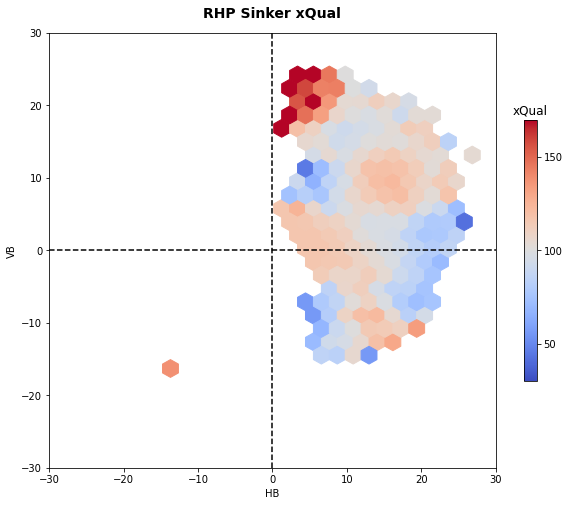

In [23]:
plt.figure(figsize = (10, 8))
plt.hexbin(si_r_stats['pfx_x'], si_r_stats['pfx_z'], C = si_r_stats['Qual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Sinker Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(si_r_stats['pfx_x'], si_r_stats['pfx_z'], C = si_r_stats['xQual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Sinker xQual', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Sinker HB & VB

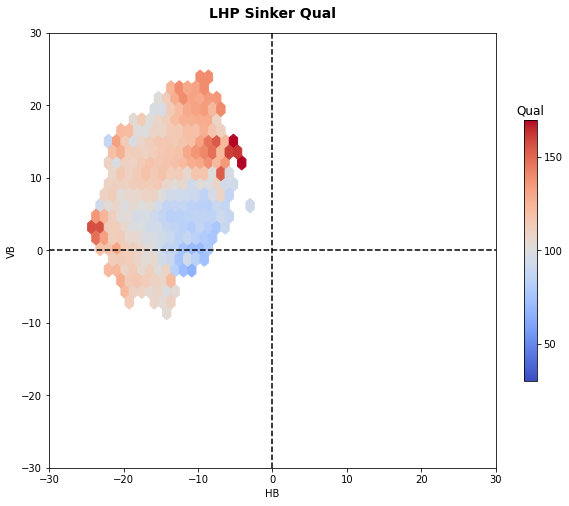

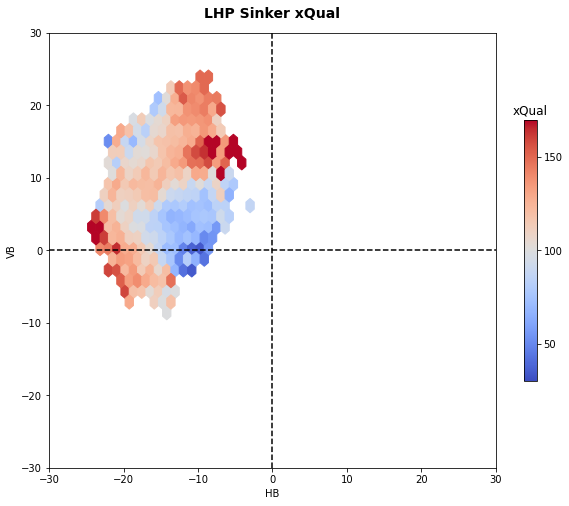

In [24]:
plt.figure(figsize = (10, 8))
plt.hexbin(si_l_stats['pfx_x'], si_l_stats['pfx_z'], C = si_l_stats['Qual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Sinker Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(si_l_stats['pfx_x'], si_l_stats['pfx_z'], C = si_l_stats['xQual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Sinker xQual', fontsize = 14, fontweight = 'bold', pad = 15);

# Slider Analysis

In [25]:
sl_stats = xrv.loc[xrv['pitch_type'] == 'SL']
sl_r_stats = sl_stats.loc[sl_stats['p_throws'] == 'R']
sl_l_stats = sl_stats.loc[sl_stats['p_throws'] == 'L']

sl_r_avg = sl_r_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
sl_l_avg = sl_l_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
sl_avg = pd.concat([sl_r_avg, sl_l_avg], ignore_index = True)
sl_avg = sl_avg.round(1)
sl_avg.head()

,pitch_type,p_throws,velo,spin_rate,pfx_x,pfx_z,release_pos_z,release_extension
0,SL,R,84.9,2438.2,-6.3,1.8,5.8,6.3
1,SL,L,83.9,2357.1,5.8,1.5,5.9,6.2


In [26]:
sl_stats[['rv', 'xRV']].describe()

,rv,xRV
count,135533.000000,135533.000000
mean,-0.033545,-0.032990
std,0.231800,0.131427
min,-1.455749,-1.118296
25%,-0.055418,-0.066394
50%,-0.028122,-0.027428
75%,0.023160,0.005616
max,3.066170,1.961266


### Top 10 Slider xQual

In [27]:
sl_stats['RV/100'] = ((sl_stats['rv'] / sl_stats['n_pitches']) * 100)
sl_stats['xRV/100'] = ((sl_stats['xRV'] / sl_stats['n_pitches']) * 100)

cols = list(sl_stats[['rv', 'xRV', 'RV/100', 'xRV/100']])
sl_stats[cols]

for col in cols:
    col_zscore = col + '_zscore'
    sl_stats[col_zscore] = ((sl_stats[col] - sl_stats[col].mean())/ sl_stats[col].std(ddof=0) * -1)

stats = sl_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                       as_index = False)['n_pitches', 'rv', 'xRV', 
                                         'rv_zscore', 'xRV_zscore'].sum()
sl_stats = pd.merge(sl_stats, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
sl_stats['Qual'] = sl_stats['rv_zscore_y'] + 100
sl_stats['xQual'] = sl_stats['xRV_zscore_y'] + 100
sl_r_stats = sl_stats.loc[sl_stats['p_throws'] == 'R']
sl_l_stats = sl_stats.loc[sl_stats['p_throws'] == 'L']

q_stats = sl_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                           as_index = False)['velo', 'pfx_x', 'pfx_z', 'RV/100', 
                                             'xRV/100', 'Qual', 'xQual'].mean()

stats = pd.merge(stats, q_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
stats = stats.round(2)
stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'n_pitches', 'velo', 
                                 'pfx_x', 'pfx_z', 'rv', 'RV/100', 'Qual', 'xRV', 'xRV/100', 'xQual'])
sl_leaders = stats.sort_values(by = ['xQual'], ascending = False)
sl_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,rv,RV/100,Qual,xRV,xRV/100,xQual
499,"Ray, Robbie",L,SL,964,88.62,0.98,7.16,-47.50,-4.93,165.42,-57.23,-5.94,293.48
516,"Rodón, Carlos",L,SL,603,85.76,8.21,-1.06,-40.56,-6.73,187.72,-43.28,-7.18,277.98
391,"McHugh, Collin",R,SL,514,79.47,-18.72,-0.61,-32.53,-6.33,165.94,-37.81,-7.36,258.67
426,"Musgrove, Joe",R,SL,815,84.07,-14.03,-1.56,-43.74,-5.37,170.76,-44.85,-5.50,236.68
522,"Rogers, Tyler",R,SL,479,71.76,-13.14,13.84,-32.73,-6.83,171.86,-31.88,-6.66,222.32
76,"Buehler, Walker",R,SL,433,84.86,-14.19,0.79,-28.90,-6.67,162.00,-30.06,-6.94,220.06
111,"Clase, Emmanuel",R,SL,310,91.85,-6.20,0.81,-21.25,-6.86,146.83,-24.20,-7.81,206.35
78,"Bummer, Aaron",L,SL,281,82.96,17.92,-5.02,-23.03,-8.20,158.69,-23.21,-8.26,206.09
686,"deGrom, Jacob",R,SL,409,91.57,-4.67,3.46,-29.75,-7.27,169.15,-27.37,-6.69,205.60
387,"McCullers Jr., Lance",R,SL,719,85.99,-13.67,4.59,-32.40,-4.51,135.73,-36.45,-5.07,196.88


### RHP Slider HB & VB

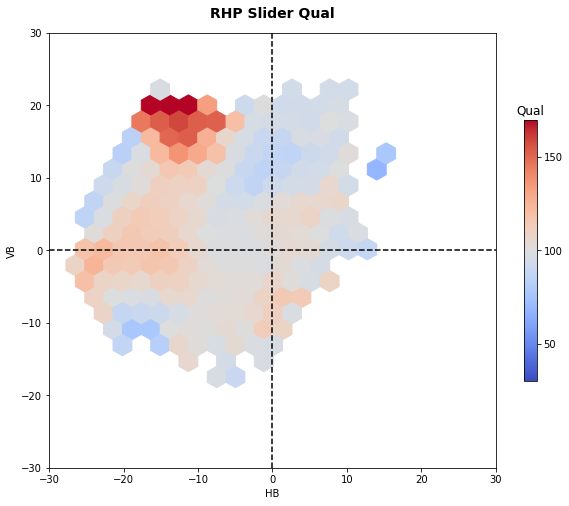

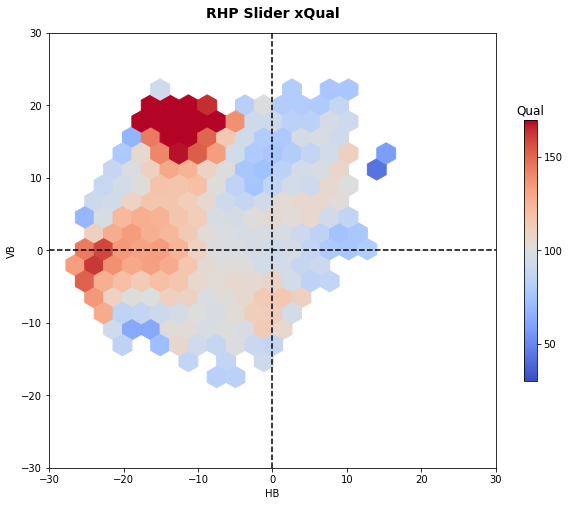

In [28]:
plt.figure(figsize = (10, 8))
plt.hexbin(sl_r_stats['pfx_x'], sl_r_stats['pfx_z'], C = sl_r_stats['Qual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Slider Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(sl_r_stats['pfx_x'], sl_r_stats['pfx_z'], C = sl_r_stats['xQual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Slider xQual', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Slider HB & VB

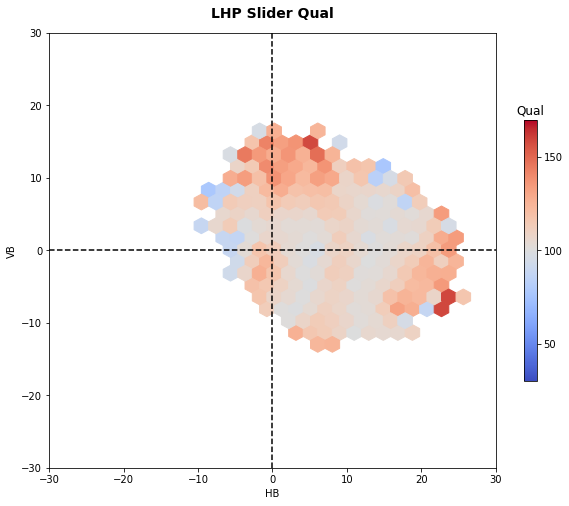

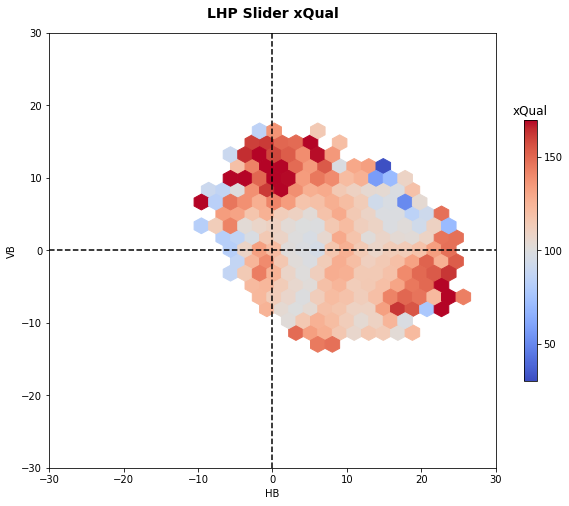

In [29]:
plt.figure(figsize = (10, 8))
plt.hexbin(sl_l_stats['pfx_x'], sl_l_stats['pfx_z'], C = sl_l_stats['Qual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Slider Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(sl_l_stats['pfx_x'], sl_l_stats['pfx_z'], C = sl_l_stats['xQual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Slider xQual', fontsize = 14, fontweight = 'bold', pad = 15);

# Curveball Analysis

In [30]:
cu_stats = xrv.loc[xrv['pitch_type'] == 'CU']
cu_r_stats = cu_stats.loc[cu_stats['p_throws'] == 'R']
cu_l_stats = cu_stats.loc[cu_stats['p_throws'] == 'L']

cu_r_avg = cu_r_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
cu_l_avg = cu_l_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
cu_avg = pd.concat([cu_r_avg, cu_l_avg], ignore_index = True)
cu_avg = cu_avg.round(1)
cu_avg.head()

,pitch_type,p_throws,velo,spin_rate,pfx_x,pfx_z,release_pos_z,release_extension
0,CU,R,79.2,2538.3,-9.6,-9.3,6.0,6.2
1,CU,L,77.7,2439.9,8.4,-7.5,6.0,6.1


In [31]:
cu_stats[['rv', 'xRV']].describe()

,rv,xRV
count,58770.000000,58770.000000
mean,-0.031498,-0.031145
std,0.210522,0.121711
min,-1.664185,-0.972581
25%,-0.043838,-0.060569
50%,-0.028122,-0.023648
75%,0.023160,0.006923
max,2.734491,1.818734


### Top 10 Curveball xQual

In [32]:
cu_stats['RV/100'] = ((cu_stats['rv'] / cu_stats['n_pitches']) * 100)
cu_stats['xRV/100'] = ((cu_stats['xRV'] / cu_stats['n_pitches']) * 100)

cols = list(cu_stats[['rv', 'xRV', 'RV/100', 'xRV/100']])
cu_stats[cols]

for col in cols:
    col_zscore = col + '_zscore'
    cu_stats[col_zscore] = ((cu_stats[col] - cu_stats[col].mean())/ cu_stats[col].std(ddof=0) * -1)

stats = cu_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                       as_index = False)['n_pitches', 'rv', 'xRV', 
                                         'rv_zscore', 'xRV_zscore'].sum()
cu_stats = pd.merge(cu_stats, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
cu_stats['Qual'] = cu_stats['rv_zscore_y'] + 100
cu_stats['xQual'] = cu_stats['xRV_zscore_y'] + 100
cu_r_stats = cu_stats.loc[cu_stats['p_throws'] == 'R']
cu_l_stats = cu_stats.loc[cu_stats['p_throws'] == 'L']

q_stats = cu_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                           as_index = False)['velo', 'pfx_x', 'pfx_z', 'RV/100', 
                                             'xRV/100', 'Qual', 'xQual'].mean()

stats = pd.merge(stats, q_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
stats = stats.round(2)
stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'n_pitches', 'velo', 
                                 'pfx_x', 'pfx_z', 'rv', 'RV/100', 'Qual', 'xRV', 'xRV/100', 'xQual'])
cu_leaders = stats.sort_values(by = ['xQual'], ascending = False)
cu_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,rv,RV/100,Qual,xRV,xRV/100,xQual
293,"Morton, Charlie",R,CU,1095,80.64,-16.57,-10.06,-59.53,-5.44,218.92,-61.22,-5.59,322.79
429,"Urías, Julio",L,CU,952,81.38,15.78,-0.93,-50.99,-5.36,199.77,-51.92,-5.45,283.01
431,"Valdez, Framber",L,CU,643,77.92,13.52,-15.30,-36.66,-5.70,177.92,-40.54,-6.30,268.53
296,"Musgrove, Joe",R,CU,698,82.07,-11.02,-13.68,-34.26,-4.91,158.31,-39.47,-5.66,245.72
147,"Glasnow, Tyler",R,CU,183,83.50,-4.63,-17.54,-20.49,-11.20,169.94,-21.01,-11.48,225.79
287,"Montgomery, Jordan",L,CU,606,79.98,0.95,-3.96,-28.91,-4.77,146.64,-33.37,-5.51,219.08
59,"Burnes, Corbin",R,CU,473,81.20,-11.27,-7.84,-28.68,-6.06,165.44,-28.55,-6.04,213.56
203,"Johnson, Pierce",R,CU,704,84.30,-10.98,-4.92,-33.34,-4.74,153.05,-34.93,-4.96,206.87
266,"McClanahan, Shane",L,CU,321,82.51,6.03,-10.68,-17.60,-5.48,135.58,-21.70,-6.76,196.16
436,"Wainwright, Adam",R,CU,1027,73.47,-16.59,-14.75,-44.61,-4.34,158.25,-43.14,-4.20,191.66


### RHP Curveball HB & VB

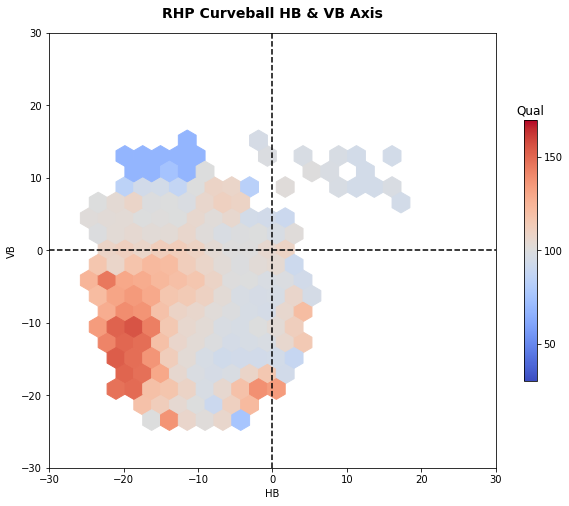

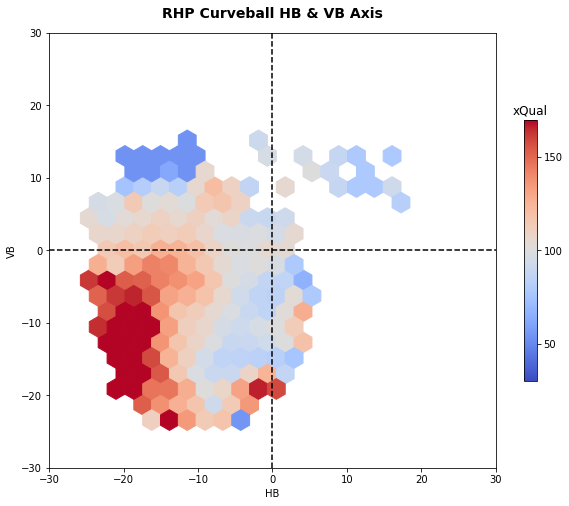

In [33]:
plt.figure(figsize = (10, 8))
plt.hexbin(cu_r_stats['pfx_x'], cu_r_stats['pfx_z'], C = cu_r_stats['Qual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Curveball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(cu_r_stats['pfx_x'], cu_r_stats['pfx_z'], C = cu_r_stats['xQual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Curveball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Curveball HB & VB

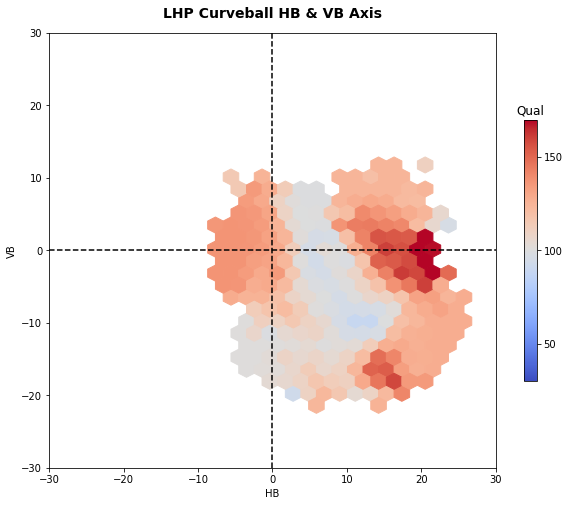

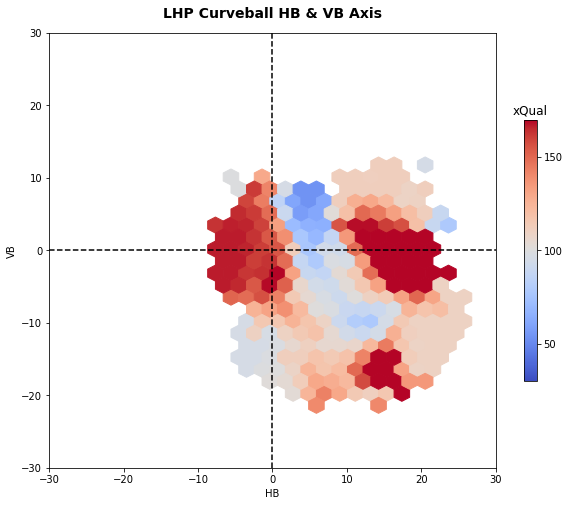

In [34]:
plt.figure(figsize = (10, 8))
plt.hexbin(cu_l_stats['pfx_x'], cu_l_stats['pfx_z'], C = cu_l_stats['Qual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Curveball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(cu_l_stats['pfx_x'], cu_l_stats['pfx_z'], C = cu_l_stats['xQual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Curveball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

# Changeup Analysis

In [35]:
ch_stats = xrv.loc[xrv['pitch_type'] == 'CH']
ch_r_stats = ch_stats.loc[ch_stats['p_throws'] == 'R']
ch_l_stats = ch_stats.loc[ch_stats['p_throws'] == 'L']

ch_r_avg = ch_r_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
ch_l_avg = ch_l_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
ch_avg = pd.concat([ch_r_avg, ch_l_avg], ignore_index = True)
ch_avg = ch_avg.round(1)
ch_avg.head()

,pitch_type,p_throws,velo,spin_rate,pfx_x,pfx_z,release_pos_z,release_extension
0,CH,R,85.5,1756.8,13.8,6.3,5.8,6.3
1,CH,L,83.6,1737.4,-13.9,7.8,5.8,6.2


In [36]:
ch_stats[['rv', 'xRV']].describe()

,rv,xRV
count,80330.000000,80330.000000
mean,-0.026356,-0.024564
std,0.231248,0.131491
min,-1.464020,-0.900000
25%,-0.055418,-0.061139
50%,-0.028122,-0.021228
75%,0.026468,0.012738
max,2.734491,1.863052


### Top 10 Changeup xQual

In [37]:
ch_stats['RV/100'] = ((ch_stats['rv'] / ch_stats['n_pitches']) * 100)
ch_stats['xRV/100'] = ((ch_stats['xRV'] / ch_stats['n_pitches']) * 100)

cols = list(ch_stats[['rv', 'xRV', 'RV/100', 'xRV/100']])
ch_stats[cols]

for col in cols:
    col_zscore = col + '_zscore'
    ch_stats[col_zscore] = ((ch_stats[col] - ch_stats[col].mean())/ ch_stats[col].std(ddof=0) * -1)

stats = ch_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                       as_index = False)['n_pitches', 'rv', 'xRV', 
                                         'rv_zscore', 'xRV_zscore'].sum()
ch_stats = pd.merge(ch_stats, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
ch_stats['Qual'] = ch_stats['rv_zscore_y'] + 100
ch_stats['xQual'] = ch_stats['xRV_zscore_y'] + 100
ch_r_stats = ch_stats.loc[ch_stats['p_throws'] == 'R']
ch_l_stats = ch_stats.loc[ch_stats['p_throws'] == 'L']

q_stats = ch_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                           as_index = False)['velo', 'pfx_x', 'pfx_z', 'RV/100', 
                                             'xRV/100', 'Qual', 'xQual'].mean()

stats = pd.merge(stats, q_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
stats = stats.round(2)
stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'n_pitches', 'velo', 
                                 'pfx_x', 'pfx_z', 'rv', 'RV/100', 'Qual', 'xRV', 'xRV/100', 'xQual'])
ch_leaders = stats.sort_values(by = ['xQual'], ascending = False)
ch_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,rv,RV/100,Qual,xRV,xRV/100,xQual
101,"Castillo, Luis",R,CH,952,88.33,16.77,0.94,-43.83,-4.60,181.04,-44.28,-4.65,258.90
594,"Urías, Julio",L,CH,483,86.81,-14.58,7.23,-27.08,-5.61,162.06,-28.90,-5.98,229.58
627,"Williams, Devin",R,CH,621,83.72,16.96,-4.16,-29.24,-4.71,155.68,-31.41,-5.06,222.90
11,"Alcantara, Sandy",R,CH,728,91.82,16.07,3.31,-31.41,-4.31,152.86,-33.73,-4.63,220.51
225,"Giolito, Lucas",R,CH,940,81.51,10.20,12.86,-38.37,-4.08,158.81,-37.76,-4.02,211.57
519,"Scherzer, Max",R,CH,421,84.98,15.16,3.95,-21.98,-5.22,147.06,-24.67,-5.86,208.93
374,"Matz, Steven",L,CH,598,85.05,-15.94,3.27,-29.60,-4.95,159.86,-28.48,-4.76,204.86
564,"Sulser, Cole",R,CH,355,83.96,13.49,5.60,-26.74,-7.53,175.16,-22.27,-6.27,203.04
403,"Montgomery, Jordan",L,CH,626,82.48,-9.74,14.71,-23.28,-3.72,129.33,-28.83,-4.61,202.34
359,"López, Pablo",R,CH,542,87.99,17.44,3.03,-23.59,-4.35,140.24,-26.51,-4.89,200.39


### RHP Changeup HB & VB

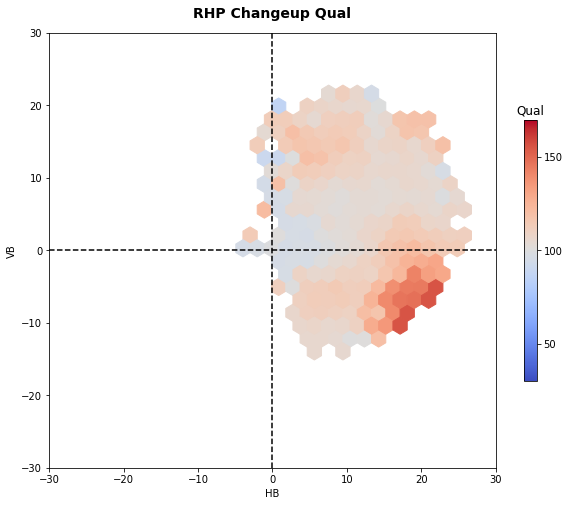

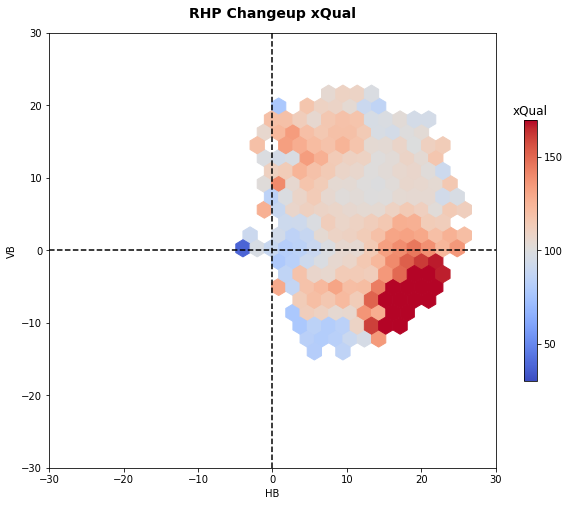

In [38]:
plt.figure(figsize = (10, 8))
plt.hexbin(ch_r_stats['pfx_x'], ch_r_stats['pfx_z'], C = ch_r_stats['Qual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Changeup Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(ch_r_stats['pfx_x'], ch_r_stats['pfx_z'], C = ch_r_stats['xQual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Changeup xQual', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Changeup HB & VB

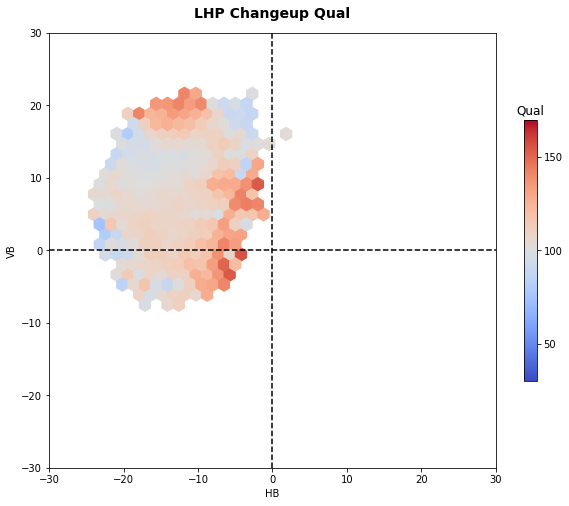

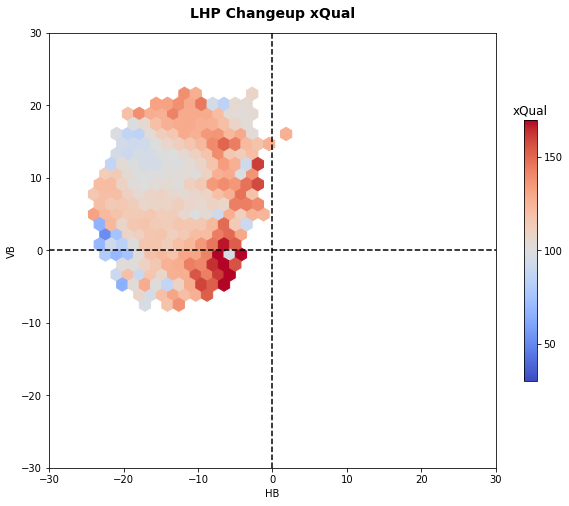

In [39]:
plt.figure(figsize = (10, 8))
plt.hexbin(ch_l_stats['pfx_x'], ch_l_stats['pfx_z'], C = ch_l_stats['Qual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Changeup Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(ch_l_stats['pfx_x'], ch_l_stats['pfx_z'], C = ch_l_stats['xQual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Changeup xQual', fontsize = 14, fontweight = 'bold', pad = 15);